In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

import pandas as pd
import numpy as np
import zipfile

import os
import sys

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
ratings = pd.read_csv('ratings.csv').drop(['Unnamed: 0'], axis=1)
providers = pd.read_csv('providers.csv')

In [58]:
ratings

,User_id,Registration number,rating
0,0,0,2.8
1,0,7932,0.7
2,0,1879,0.4
3,0,7931,0.9
4,0,1880,1.8
...,...,...,...
109340,19,472,3.1
109341,19,2515,4.9
109342,19,2516,5.0
109343,19,2517,2.7


### 1. Найдем схожесть между элементами
1. найдем пользователей, которые оценили один и то же элемент
2. нормализуем рейтинги
3. рассчитаем косинусное расстояние для нормализованных рейтингов

In [59]:
def normalize():
    
    # средний рейтинг по каждому пользователю
    mean = ratings.groupby(by='User_id', as_index=False)['rating'].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='User_id')
    
    # нормализуем все рейтинги относительно среднего
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    return mean.to_numpy()[:, 1], norm_ratings

In [60]:
mean, norm_ratings = normalize()
np_ratings = norm_ratings.to_numpy()
norm_ratings

,User_id,Registration number,rating,rating_mean,norm_rating
0,0,0,2.8,2.51721,0.28279
1,0,7932,0.7,2.51721,-1.81721
2,0,1879,0.4,2.51721,-2.11721
3,0,7931,0.9,2.51721,-1.61721
4,0,1880,1.8,2.51721,-0.71721
...,...,...,...,...,...
109340,19,472,3.1,2.48049,0.61951
109341,19,2515,4.9,2.48049,2.41951
109342,19,2516,5.0,2.48049,2.51951
109343,19,2517,2.7,2.48049,0.21951


In [61]:
mean

array([2.51720991, 2.50234467, 2.50288745, 2.52358987, 2.46925899,
       2.48190337, 2.50443316, 2.50924002, 2.51825221, 2.51306122,
       2.52432332, 2.51384909, 2.48101769, 2.4679558 , 2.47308766,
       2.50564678, 2.49683858, 2.56511407, 2.49804805, 2.4804902 ])

In [62]:
# создадим CSR матрицу
def item_representation(ratings):    
    return csr_matrix(
        pd.crosstab(ratings['Registration number'], ratings['User_id'], ratings.norm_rating, aggfunc=sum).fillna(0).values
    )

In [63]:
R = item_representation(norm_ratings)

In [64]:
R.size

109345

In [65]:
# knn 
def create_model(rating_matrix, k=21, metric="cosine"):
    """
    - создание модели с базовыми параметрами
    """
    model = NearestNeighbors(metric=metric, n_neighbors=k, algorithm='brute')
    
    
    model.fit(rating_matrix)    
    return model

In [66]:
# расчет схожести
def nearest_neighbors(rating_matrix, model):
    """
    :param rating_matrix : матрица рейтингов (nb_users, nb_items)
    :param model : модель knn  
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)        
    return similarities[:, 1:], neighbors[:, 1:]

### Ajusted Cosine Similarity (скорректированое)
Работа с элементами, лучше всего заменить обычное косинусное сходство на скорректированое, т.к. пользователи могут завышать или занижать оценки. Каждый ставит оценку по своему "ощущению"
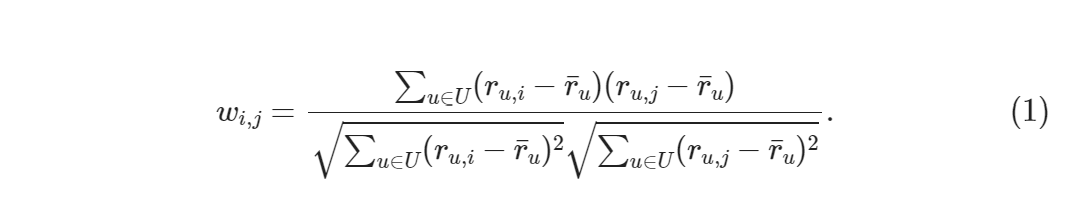


In [67]:
def save_similarities(similarities, neighbors, dataset_name):    
    base_dir = 'sims'
    save_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(save_dir, exist_ok=True)    
    similarities_file_name = os.path.join(save_dir, 'similarities.npy')
    neighbors_file_name = os.path.join(save_dir, 'neighbors.npy')    
    try:
        np.save(similarities_file_name, similarities)
        np.save(neighbors_file_name, neighbors)        
    except ValueError as error:
        print(f"Ошибка во время сохранения : \n ValueError : {error}")

        
def load_similarities(dataset_name, k=20):
    base_dir = 'sims'
    save_dir = os.path.join(base_dir, dataset_name)    
    similiraties_file = os.path.join(save_dir, 'similarities.npy')
    neighbors_file = os.path.join(save_dir, 'neighbors.npy')    
    similarities = np.load(similiraties_file)
    neighbors = np.load(neighbors_file)    
    return similarities[:,:k], neighbors[:,:k]


def cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def adjusted_cosine(np_ratings, nb_items, items, dataset_name):
    similarities = np.zeros(shape=(nb_items, nb_items))
    similarities.fill(-1)
    
    def _progress(count):
        sys.stdout.write('\rComputing similarities. Progress status : %.1f%%' % (float(count / nb_items)*100.0))
        sys.stdout.flush()
        
    for i in items[:-1]:
        for j in items[i+1:]:         
            if i <= 10000 and j <= 10000:
            
                scores = np_ratings[(np_ratings[:, 1] == i) | (np_ratings[:, 1] == j), :]
                vals, count = np.unique(scores[:,0], return_counts = True)
                scores = scores[np.isin(scores[:,0], vals[count > 1]),:]

                if scores.shape[0] > 2:
                    x = scores[scores[:, 1].astype('int') == i, 4]
                    y = scores[scores[:, 1].astype('int') == j, 4]
                    w = cosine(x, y)
                    similarities[i, j] = w
                    similarities[j, i] = w
            else:
                pass
            
        _progress(i)
    _progress(nb_items)
    
    # получаем и сортируем ближайших соседей
    neighbors = np.flip(np.argsort(similarities), axis=1)
    
    # сортируем рейтинги 
    similarities = np.flip(np.sort(similarities), axis=1)
    
    # сохраняем
    save_similarities(similarities, neighbors, dataset_name=dataset_name) 
    
    return similarities, neighbors

In [68]:
# очень много объектов, предложите идею сокращения размерности?

nb_items = 10000 #ratinvalue_countsId.nunique()
similarities, neighbors = adjusted_cosine(np_ratings, nb_items=nb_items, items = ratings['Registration number'].unique(), dataset_name='ml')

Computing similarities. Progress status : 88.2%

KeyboardInterrupt: 

### 2. Top N рекомендаций для пользователя
1. Найдем элементы-кандидаты для рекомендации
2. Выбирем элементы, который пользователь уже оценил
3. Сделаем расчет сходства по всем элементам
4. Исключим уже отмеченные пользователем элементы

In [ ]:
np.set_printoptions(precision=2, floatmode='fixed')

In [ ]:
np_ratings[np_ratings[:, 0] == 0][:, 1].astype('int64')

In [ ]:
def candidate_items(userid):
    """
    :param userid : пользователь чей набор рекомендаций собираем 
    :return : элементы в наборе
    """
    
    # 1. Выбирем элементы, который пользователь уже оценил
    I_u = np_ratings[np_ratings[:, 0] == userid]
    I_u = I_u[:, 1].astype('int64')
    
    # 2. Сделаем расчет сходства по всем элементам
    c = set()
        
    for iid in I_u:    
        # добавим соседей выбранного элемента
        c.update(neighbors[iid])
        
    c = list(c)
    # 3. Исключим уже отмеченные пользователем элементы
    candidates = np.setdiff1d(c, I_u, assume_unique=True)
    
    return I_u, candidates

In [ ]:
i_u, u_candidates = candidate_items(2)

In [ ]:
print('кол-во элементов по пользователю : ', len(i_u))
print('кол-во возможных рекомендаций для пользователя : ', len(u_candidates))

In [ ]:
def similarity_with_Iu(c, I_u):
    """
    функция поиска сходства
    """
    w = 0    
    for iid in I_u :        
        # схожесть между элементами (по элементно)
        # наш совместный код
        
        
    return w

In [ ]:
def rank_candidates(candidates, I_u):
    """
    расчет рангов и общая сортировка всех элементов
    """
    
    # из списка элементов вычисляем для каждого схожесть
    sims = [similarity_with_Iu(c, I_u) for c in candidates]  
    mapping = list(zip(candidates, sims))
    
    # сортируем результаты по рейтингу
    ranked_candidates = sorted(mapping, key=lambda couple:couple[1], reverse=True)    
    return ranked_candidates

In [ ]:
def topn_recommendation(userid, N=10):
    """
    функция отбора Топ-N рекомендаций
    """
    # поиск элементов
    I_u, candidates = candidate_items(userid)
    
    #  сортировка элементов 
    ranked_candidates = rank_candidates(candidates, I_u)
    
    # отбор Топ-N
    topn = pd.DataFrame(ranked_candidates[:N], columns=['Registration number','similarity_with_Iu'])    
    topn = pd.merge(topn, movies, on='Registration number', how='inner')    
    return topn

In [ ]:
topn_recommendation(2)